
# Working with a hand radiograph. 

Hand radiograph are obtained from [2017 Radiological Society of North America competition](http://rsnachallenges.cloudapp.net/competitions/4). 

X-ray intensities are high in dense tissue such as bone. Such images can be used to predict "bone age " in children.

## Loading images

In [2]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi  # 
import matplotlib.style as style
style.use('fivethirtyeight')


im = imageio.imread('Data/hand.png')

print('Data type:', im.dtype)
print('Min. value:', im.min())
print('Max value:', im.max())

Data type: uint8
Min. value: 3
Max value: 224


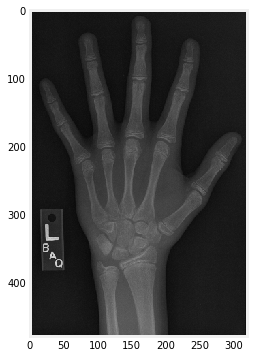

In [3]:
# normalize luminance data using vmin and vmax. 
plt.figure(figsize=(6,6))
plt.imshow(im, vmin=0, vmax=255, cmap='gray')
plt.grid()

### Visualizing distribution of values

The distribution of values can be visualized using a histogram. The frequency with which a given range of pixel intensies occur is derived using the CDF (cumulative distribution function)

The 'intensity distribution' is thus discribed using the histogram and CDF


The CDF is simply calculated by,

- First: finding the cumulative sum of `hist()`,
- then dividing by the total number of pixels in `hist()`.

Text(0.5,1,'CDF')

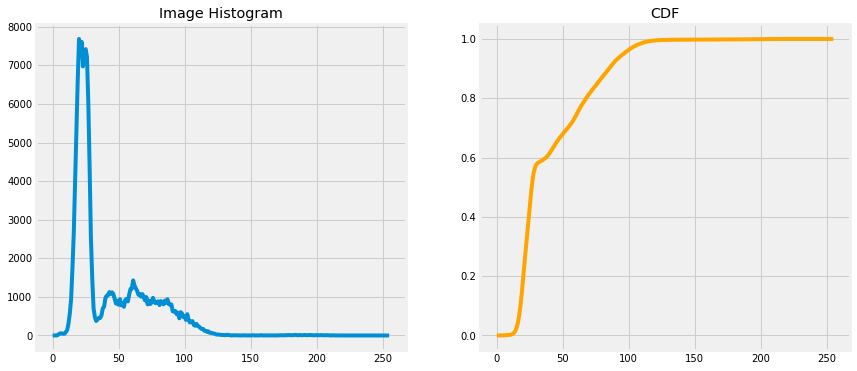

In [4]:
# Create a histogram, binned at each possible value

# Generates a 256-bin histogram of image which covers the full range of np.uint8 values.
hist = ndi.histogram(im, min=0, max=255, bins=256)

# Create a cumulative distribution function
cdf = hist.cumsum() / hist.sum()

# Plot the histogram and CDF
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(13,6))
ax[0].plot(hist, label='Histogram')
ax[0].set_title('Image Histogram')
ax[1].plot(cdf, label='CDF', color='orange')
ax[1].set_title('CDF')

## Image Masks


We can restrict the analysis to only the most important part of an image by creating and applying something called as "Image Masks"


A Mast is a boolean array which serves as a screen to remove undesirable pixels. A mask should retain the same dimension as the original image so that the two (the original image and the mask) can be overlayed upon eash other. 

A Mask can be created is by finding all "pixels" in an image that satisfy a certain condition. 

For example in the above Hand histogram we can see that the values tend to drop around 35. So we can create a mask for all the pixel intensities above this. 

(-0.5, 319.5, 479.5, -0.5)

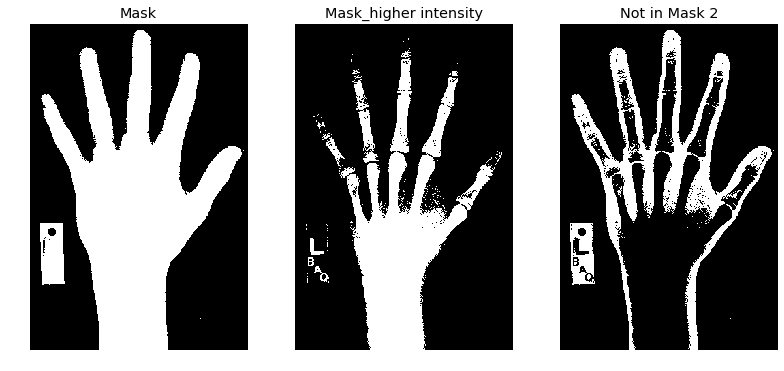

In [5]:
mask_1 = im > 35
mask_2 = im > 64

mask_3 = mask_1 & ~mask_2

fig, ax = plt.subplots(1, 3, sharex=True, figsize=(12,6))
ax[0].imshow(mask_1, cmap='gray')
ax[1].imshow(mask_2, cmap='gray')
ax[2].imshow(mask_3, cmap='gray')
ax[0].set_title(label='Mask')
ax[1].set_title(label= 'Mask_higher intensity')
ax[2].set_title(label = 'Not in Mask 2')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

- This does a decent job masking out the original image. 

- We can also see that increasing the threshold to 64, creates a 'bone mask'. 

- Finally a mask of non-bone tissue, by finding pixels that are in mask1 but not in mask2. The selected pixels seems to be more   part of the skin than of the bone. 

#### Alternative

Although masks are binary, they can be applied to images to filter out pixels where the mask is False. This is simply done using NumPy's `where()` function.

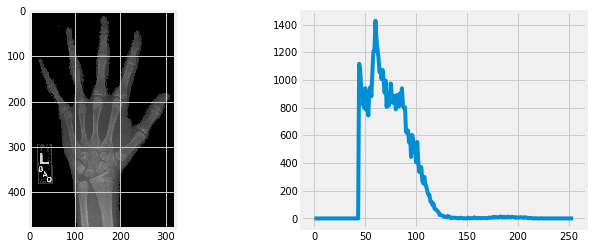

In [6]:
# Screen out non-bone pixels from "im"
mask_bone = im >= 45
im_bone = np.where(mask_bone, im, 0)

# Get the histogram of bone intensities
hist = ndi.histogram(im_bone, min=1, max=255, bins=255)

# Plot masked image and histogram
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(im_bone, cmap='gray')
ax[1].plot(hist)

## Mask Tuning  

Imperfect mask can lead to a wrong picture of the whole image. Specifically when two images are joint in some way, it is important to separate out the masks. 

Imperfect masks can be tuned through the addition and subtraction of pixels. We can use SciPy which includes several useful methods for accomplishing these ends. These are;

- `binary_dilation`: Add pixels along edges
- `binary_erosion`: Remove pixels along edges
- `binary_opening`: Erode then dilate, "opening" areas near edges
- `binary_closing`: Dilate then erode, "filling in" holes


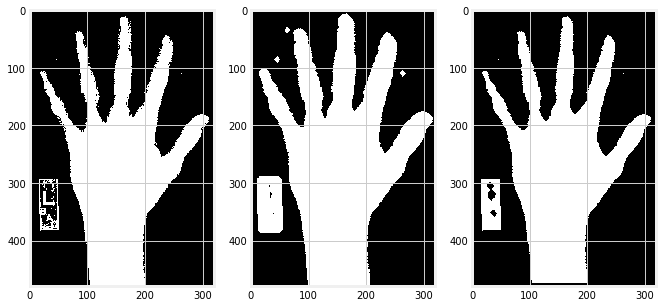

In [16]:
# Create and tune bone mask
# create bone by selecting pixels greater than a threshold
mask_bone = im >= 45

# ndi.binary_dilation increases the size of the mask_bone
# ndi.binary_closing fills hole in mask_bone

mask_dilate = ndi.binary_dilation(mask_bone, iterations=5)
mask_closed = ndi.binary_closing(mask_bone, iterations=5)

# Plot original and tuned image masks
fig, axes = plt.subplots(1,3, figsize=(10,6))
axes[0].imshow(mask_bone, cmap='gray')
axes[1].imshow(mask_dilate, cmap='gray')
axes[2].imshow(mask_closed, cmap='gray')

## Filters

Intensity and spacial information can be combined using convolutional filters. 


- Smoothing 
Supresses the noise by blurring the image. 

- Sharpening
Sharpening is the opposite. Shaprp changes are enhanced by exgerrating the differences between the pixels. 



Text(0.5,1,'Smoothed Image')

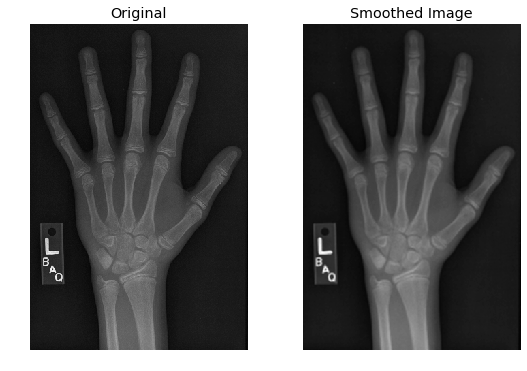

In [17]:
# Set filter weights
weights = [[0.11, 0.11, 0.11],
           [0.11, 0.11, 0.11], 
           [0.11, 0.11, 0.11]]


im_filt = ndi.convolve(im, weights)

# Plot the images
fig, ax = plt.subplots(1,2, figsize=(8,6))
ax[0].imshow(im, cmap='gray')
ax[1].imshow(im_filt, cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title(label='Original')
ax[1].set_title(label= 'Smoothed Image')

### Alternative filter functions

Convolutions rely on a set of weights, but filtering can also be done using functions such as the mean, median and maximum. Just like with convolutions, filter functions will update each pixel value based on its local neighborhood.

In [9]:
im_test = np.array([[93, 36,  87], 
               [18, 49,  51],
               [45, 32,  63]])

im_filt = ndi.median_filter(im_test, size=3)


im_filt

array([[49, 51, 51],
       [45, 49, 51],
       [45, 45, 51]])

## Smoothing

Smoothing can improve the signal-to-noise ratio of the image. It does this by blurring out small variations in intensity. 

The Gaussian filter fits perfectly for this: it is a circular (or spherical) smoothing kernel that weights nearby pixels higher than distant ones

The width of the distribution is controlled by the **sigma** parameter, with higher values leading to larger smoothing effects.

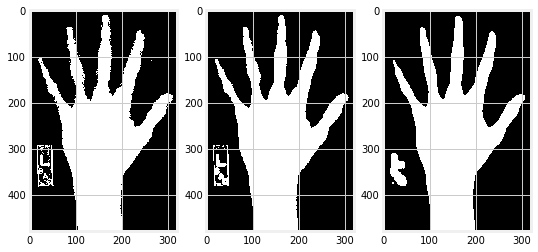

In [15]:
# Smooth "im" with Gaussian filters
im_s1 = ndi.gaussian_filter(im, sigma=1)
im_s3 = ndi.gaussian_filter(im, sigma=3)

# Draw bone masks of each image
fig, ax = plt.subplots(1,3, figsize=(8,6))
ax[0].imshow(im >= 45, cmap='gray')
ax[1].imshow(im_s1 >= 45, cmap='gray')
ax[2].imshow(im_s3 >=45, cmap='gray')

# Feature Detection

Features can also be used as *detectors* as features of interest like detection of edges.   

Edge is a **change in intensity** along a axis. Sharp edges have a very high contrast. 

We do this by constructing a kernel/filter. We look for change in intersity from the top to bottom. We then convolve the image with the filter using `ndi.convolve()` 

There are many possible filters for edge detectors. A very common one are *Sobel filters*. Sobel filters provide an extra weight to the centre pixels of the kernel. The filters can be flipped to make it sensitive towards horizantal or vertical edges. Scipy does this using `ndi.sobel()`. 

A filter detecting horizontal edges might look like this. 

In [46]:
weights = [[+1, +1, +1],
           [ 0,  0,  0],
           [-1, -1, -1]]

Lets create a 3x3 array of filter weights that detects when intensity changes from the left to right. This does the job of a vertical edge detector. 

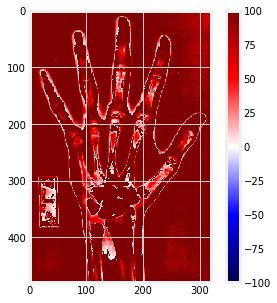

In [50]:
# # Set weights to detect vertical edges
weights = [[-1, 0, -1], 
            [-1, 0, -1], 
            [-1, 0, -1]]

# Convolve "im" with filter weights
edges = ndi.convolve(im, weights)

# Draw the image in color
plt.figure(figsize=(5,5))
plt.imshow(edges, vmin=-100, vmax=100, cmap='seismic')
plt.colorbar()

Edge detection can be performed along multiple axes, then combined into a single edge value. For 2D images, the horizontal and vertical "edge maps" can be combined using the Pythagorean theorem:

$z = \sqrt{x^2 + y^2}$

This is illustrated below. 

In [51]:
# Apply Sobel filter along both axes
sobel_ax0 = ndi.sobel(im, axis=0)
sobel_ax1 = ndi.sobel(im, axis=1)

# Calculate edge magnitude 
edges = np.sqrt(np.square(sobel_ax0) + np.square(sobel_ax1))

# Plot edge magnitude
edges.shape

(480, 320)

Thats about it with respect to masking images, using filter techniques such as convolutions and sobel filters. 